# Estimation des paramètres

In [1]:
import utilities
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import spacy
import re
import sklearn
import random
import textdistance

from spacy.vocab               import Vocab
from spacy.language            import Language
from spacy.tokens              import Token
from spacymoji                 import Emoji
from   sklearn.tree            import DecisionTreeClassifier
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import confusion_matrix






Importation du corpus.

In [2]:
corpus = pd.read_csv("C:/Users/a.tekiouk/Sujet_2/Sujet_2/DATA/chanel10k.csv", sep=";", parse_dates=["publication_time"])

# on récupére les posts en anglais
mask = corpus["language"] == 'en'
corpus = corpus.loc[mask]
chanel = corpus['text'].tolist()
publication_time_chanel = corpus['publication_time'].tolist()

print(f"# documents in corpus: {len(chanel)}")

# documents in corpus: 1802


### Estimation du seuil de la distance de Levenshtein normalisée

In [3]:
corpus_test = corpus[['text','publication_time']].sample(n= 100, random_state = 42)

In [4]:
def nb_per_thresholds(
    corus   : pd.DataFrame,
    )-> tuple[list,list]:
    """
    Return the number of post after deleting the posts with similar text and all the threshholds tested.

    Parameters
    ----------
    corus   : pd.DataFrame
    """
    nb_remaing_posts = []
    thresholds = np.linspace(0,1,20)
    dist = textdistance.levenshtein.normalized_distance
    for limit in thresholds:
        nb_remaing_posts.append(len(utilities.delete_duplicates(corpus_test['text'].tolist(),corpus_test['publication_time'].tolist(),limit,dist)))
    return thresholds,nb_remaing_posts
        

In [5]:
x,y = nb_per_thresholds(corpus_test)


In [11]:
y = [i*100/max(y) for i in y]

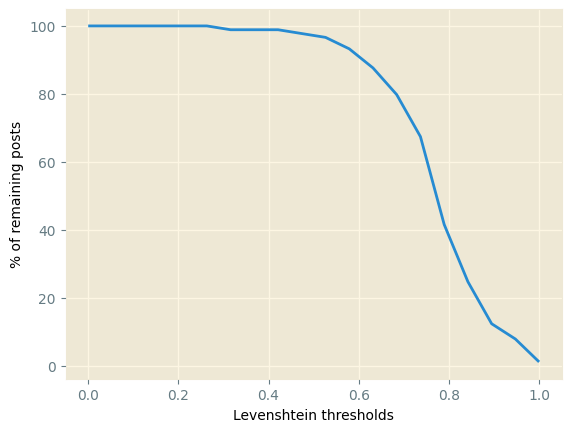

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
with plt.style.context('Solarize_Light2'):
    plt.plot(x, y)
    plt.xlabel('Levenshtein thresholds')
    plt.ylabel('% of remaining posts')